In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:

import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint
import re
import numpy as np
import os
import io
import time
import math

In [3]:
#%load_ext tensorboard

In [4]:
df=pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)

In [5]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
sentiments=df[0].values
sentences=df[5].values

In [7]:
sentiments[sentiments==4]=1

In [8]:
sentiments[1],sentences[1]

(0,
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!")

In [9]:
total=len(df)

In [10]:
split=int(0.95*total)

In [11]:
split

1520000

In [12]:
test_sentiments=sentiments[split:]
test_sentences=sentences[split:]

In [13]:
# def preprocess(sentence,sentiment):
# #     sentence = tf.strings.lower(sentence)
# #     sentence = tf.strings.regex_replace(sentence,'[^a-zA-Z0-9?.!,\'\"]',' ')
# #     words_list = tf.strings.split(sentence)
# #     sentence = tf.strings.reduce_join(words_list,separator=" ", axis=-1)
#     sentiment = tf.one_hot(sentiment, 2)
    
#     return sentence, sentiment
    
    

In [14]:
batch_size=2000
train = tf.data.Dataset.from_tensor_slices((tf.constant(sentences),tf.constant(sentiments)))
# train = train.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train = train.cache().shuffle(total)
train = train.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [15]:
example_input_batch, example_target_batch = next(iter(train))
example_input_batch[-1], example_target_batch[-1]

(<tf.Tensor: shape=(), dtype=string, numpy=b'@iFrankM my sister and I were about to head over to Yard House but they have 0 free tables '>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [16]:
example_input_batch[0], example_target_batch[0]

(<tf.Tensor: shape=(), dtype=string, numpy=b"@mjh81 lols  didn't wanna watch it really . . . Lmao!">,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>)

In [17]:
batch_size=1000
test = tf.data.Dataset.from_tensor_slices((tf.constant(test_sentences),tf.constant(test_sentiments)))
# test = test.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test.cache().shuffle(len(test_sentences))
test = test.batch(batch_size)

In [18]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1", output_shape=[128],
                           input_shape=[], dtype=tf.string, trainable=True)

In [19]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,1)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(160,return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(160)))
model.add(tf.keras.layers.Dense(160, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(30, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
lambda (Lambda)              (None, 1, 128)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 320)            369920    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 320)               615680    
_________________________________________________________________
dense (Dense)                (None, 160)               51360     
_________________________________________________________________
dropout (Dropout)            (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                4

In [21]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [22]:
# import datetime

filepath="cp/sentiment_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# callbacks_list = [checkpoint]
!mkdir cp



# log_dir='logs/fit/'+ datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

# tb=tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

callbacks_list = [checkpoint]

In [23]:
# !mkdir logs
# !mkdir logs/fit/

In [24]:
# %tensorboard --logdir logs/fit

In [25]:
history = model.fit(train, epochs=120,validation_data=test, callbacks=callbacks_list)

Train for 800 steps, validate for 80 steps
Epoch 1/120
799/800 [============================>.] - ETA: 0s - loss: 0.4435 - accuracy: 0.7940
Epoch 00001: val_loss improved from inf to 0.40717, saving model to cp/sentiment_model.hdf5
800/800 [==============================] - 61s 76ms/step - loss: 0.4435 - accuracy: 0.7940 - val_loss: 0.4072 - val_accuracy: 0.7922
Epoch 2/120
799/800 [============================>.] - ETA: 0s - loss: 0.3987 - accuracy: 0.8180
Epoch 00002: val_loss improved from 0.40717 to 0.39342, saving model to cp/sentiment_model.hdf5
800/800 [==============================] - 52s 65ms/step - loss: 0.3987 - accuracy: 0.8180 - val_loss: 0.3934 - val_accuracy: 0.8027
Epoch 3/120
799/800 [============================>.] - ETA: 0s - loss: 0.3699 - accuracy: 0.8328
Epoch 00003: val_loss improved from 0.39342 to 0.35056, saving model to cp/sentiment_model.hdf5
800/800 [==============================] - 52s 65ms/step - loss: 0.3699 - accuracy: 0.8328 - val_loss: 0.3506 - val_

In [26]:
model.load_weights("cp/sentiment_model.hdf5")

<Figure size 432x288 with 0 Axes>

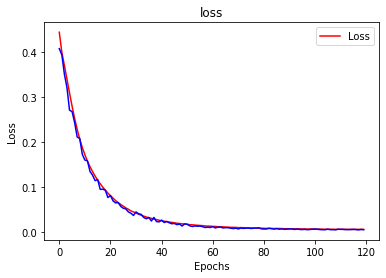

<Figure size 432x288 with 0 Axes>

In [27]:

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']
v_loss=history.history['val_loss']


epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, v_loss, 'b')
plt.title('loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [28]:
def predict(text):
    start_at = time.time()
    
    score = model.predict([text])[0]

    return {"negative": float(score[0]), "postive": float(score[1]),
       "elapsed_time": time.time()-start_at}  

In [29]:
predict("the product made my skin glow but it had severe side effects")

{'negative': 1.0,
 'postive': 1.2868395585230452e-12,
 'elapsed_time': 1.1083214282989502}

In [30]:
predict("Blackpink is the greatest girl band ever.")

{'negative': 4.458362845571884e-11,
 'postive': 1.0,
 'elapsed_time': 0.031017780303955078}